In [1]:
%run init_notebook.py
from settings import DATA_DIR

In [351]:
import pandas as pd
import numpy as np

import eurostat

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from scipy.stats import normaltest

import os

In [81]:
def get_samp(max_dim, size=100):
    return np.random.randint(0, max_dim, min(size, max_dim))

In [3]:
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement"""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

In [4]:
# eurostat

In [9]:
# codes = eurostat.get_toc_df()

# [i for i in codes['title'] if 'gdp'.lower() in i.lower()];
# data = eurostat.get_data('prc_hicp_midx', filter_pars={'geo': ['DE','FR']})

In [ ]:
df = pd.DataFrame(data[1:], columns=data[0]).transpose()
df = df.loc[:, (df.loc['unit'] == 'I05') & (df.loc['coicop'] == 'CP00')]
df.columns = [f'cpi_{i}' for i in df.loc['geo\TIME_PERIOD'].values]

cpi = df.iloc[5:].copy().dropna().astype(float)
cpi.index = [datetime(int(i[:4]), int(i[5:7]), 1) for i in cpi.index]

In [ ]:
cpi['pi_de'] = np.log(cpi['cpi_DE']).diff()

In [ ]:
cpi.to_csv(os.path.join(DATA_DIR, 'cpi.csv'))

In [7]:
# load data

In [8]:
cpi = pd.read_csv(os.path.join(DATA_DIR, 'cpi.csv'))

In [9]:
cpi = cpi.rename(columns={'Unnamed: 0': 'date'})
cpi['date'] = cpi['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
cpi.set_index('date', inplace=True)

In [10]:
# analyse

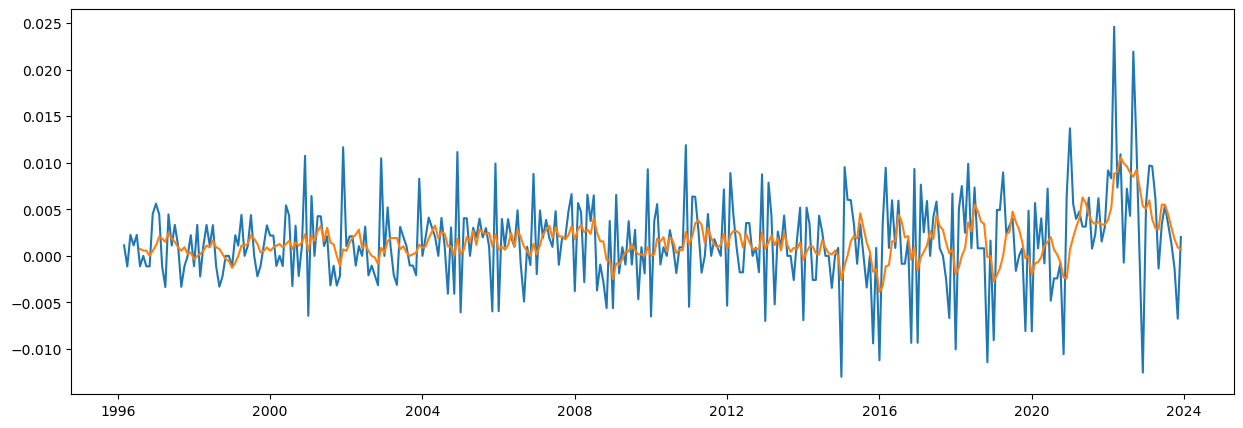

In [11]:
fig = plt.figure(figsize=(15, 5))
plt.plot(cpi.index, cpi['pi_de']) # s=5)
plt.plot(cpi.pi_de.rolling(6).mean())

In [12]:
# model

In [13]:
t = cpi.index.dropna().date
cpi['t'] = np.array((t - t.min()) / (t.max() - t.min()))

In [15]:
_train = cpi.dropna().loc[datetime(2010,1,1):datetime(2020,3,1)].copy()
_test = cpi.dropna().loc[datetime(2020,3,1):].copy()

In [16]:
t, y = _train['t'].values.astype(float), _train['pi_de'].values.astype(float)
t_test, y_test = _test['t'].values.astype(float), _test['pi_de'].values.astype(float)

In [17]:
with pm.Model() as linear:
    alpha = pm.Normal("alpha", mu=0, sigma=0.05)
    beta = pm.Normal("beta", mu=0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=0.05)
    trend = pm.Deterministic("trend", alpha + t * beta)
    pm.Normal("likelihood", mu=trend, sigma=sigma, observed=y)

    linear_prior_predictive = pm.sample_prior_predictive(samples=100)

Sampling: [alpha, beta, likelihood, sigma]


In [18]:
samp = linear_prior_predictive.prior

''

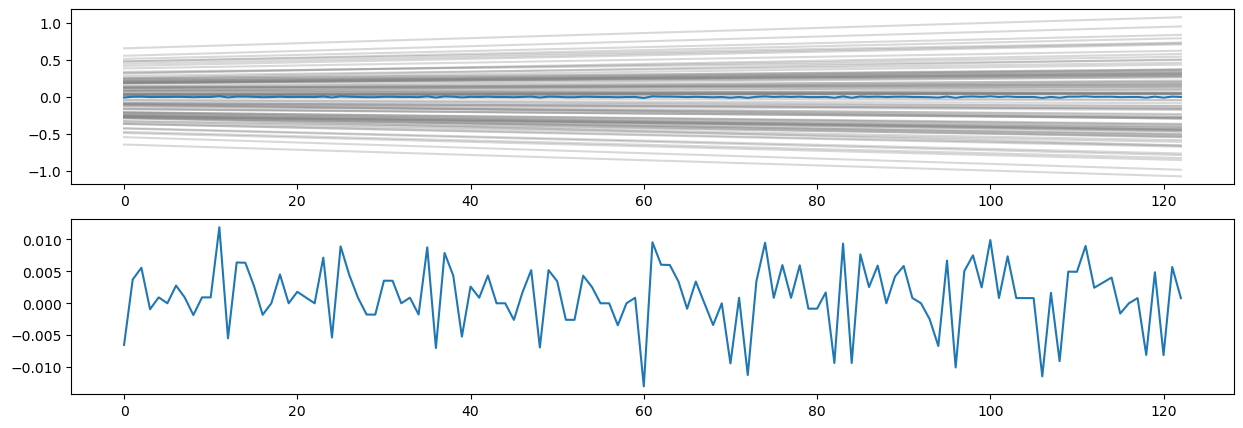

In [19]:
fig, ax = plt.subplots(2,1, figsize=(15,5))
ax[0].plot(
    samp['alpha'].values + t.reshape(len(t),1) @ samp['beta'].values + samp['sigma'].values,
    alpha=.3, color='grey'
)
ax[0].plot(y)
ax[1].plot(y)
;

In [20]:
with linear:
    linear_posterior_sample = pm.sample(return_inferencedata=True)
    linear_posterior_predictive = pm.sample_posterior_predictive(linear_posterior_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Sampling: [likelihood]


''

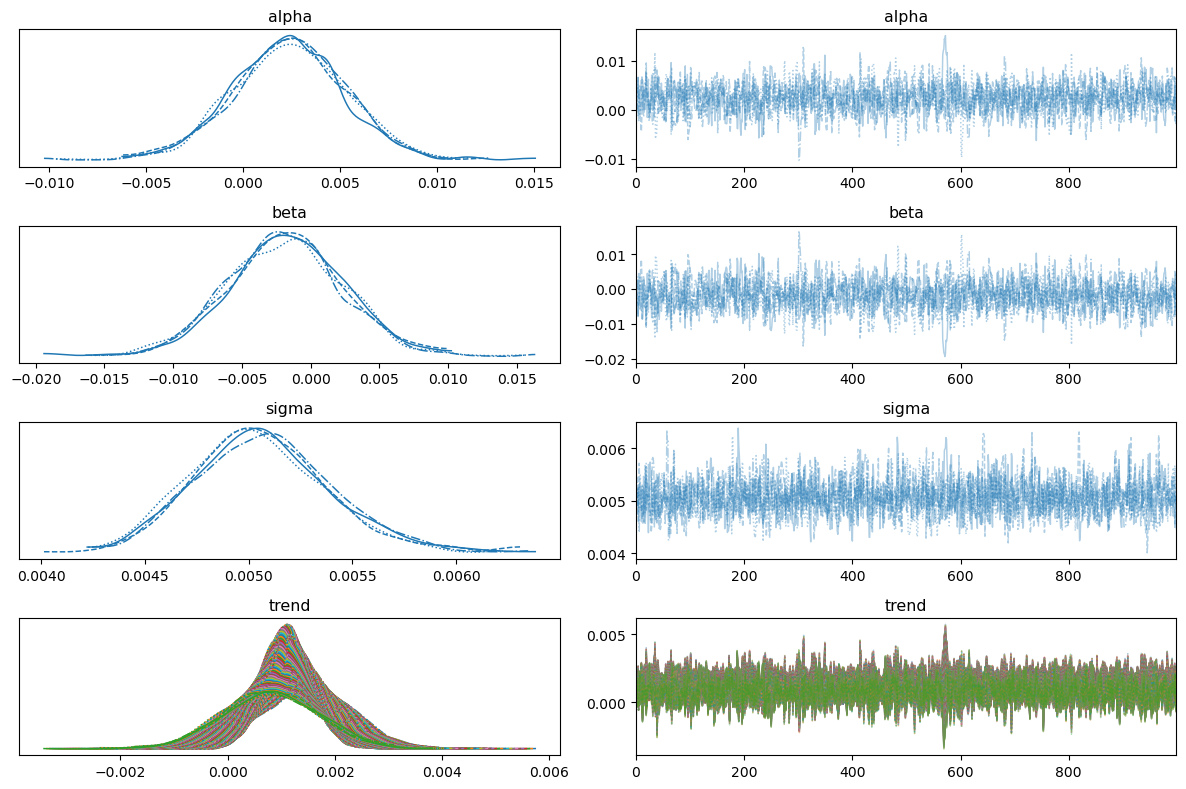

In [21]:
az.plot_trace(linear_posterior_sample)
plt.tight_layout()
;

''

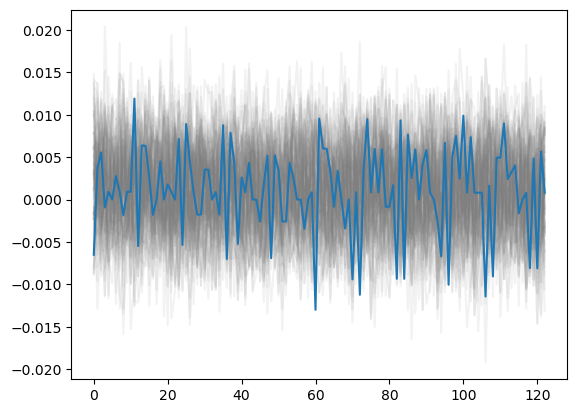

In [86]:
plt.plot(
#     _sample(linear_posterior_predictive.posterior_predictive['likelihood'][0], 100).transpose(), 
    linear_posterior_predictive.posterior_predictive['likelihood'][0, get_samp(1_000, 100), :].values.T,
    alpha=.1, 
    color='grey'
)
plt.plot(y)
;

In [87]:
# seasonal

In [215]:
n_order = 10
periods = _train.reset_index()['date'].dropna().dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

periods = _test.reset_index()['date'].dropna().dt.dayofyear / 365.25
fourier_features_test = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
# fourier_features

In [97]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    alpha = pm.Normal("alpha", mu=0, sigma=0.5)
    beta = pm.Normal("beta", mu=0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    beta_f = pm.Normal("beta_f", mu=0, sigma=10, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(beta_f, fourier_features.to_numpy().T)
    )
    trend = pm.Deterministic("trend", alpha + beta * t)
    mu = trend * (1 + seasonality)
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)

    linear_with_seasonality_prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, beta, beta_f, likelihood, sigma]


''

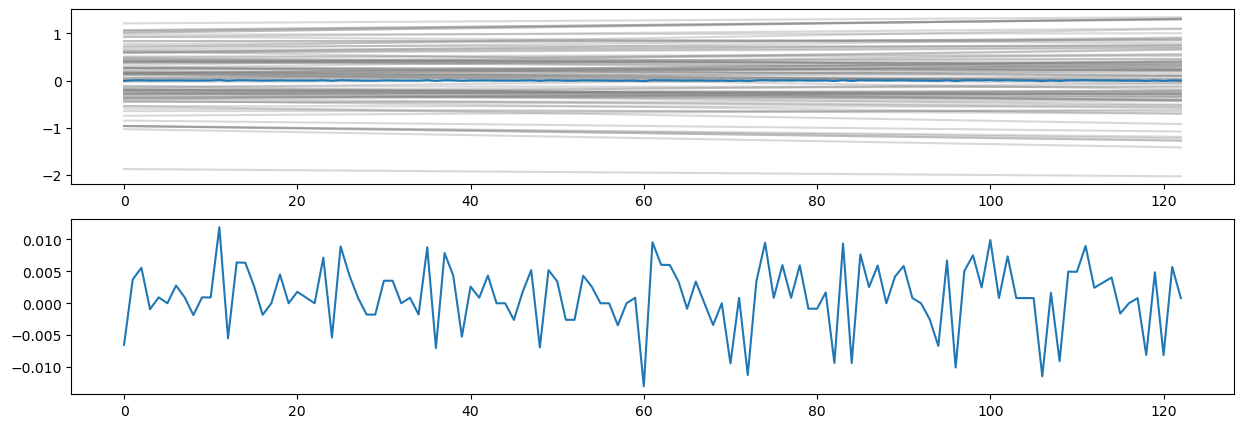

In [98]:
fig, ax = plt.subplots(2,1, figsize=(15,5))
ax[0].plot(
#     samp['alpha'].values + t.reshape(len(t),1) @ samp['beta'].values + samp['sigma'].values,
    _sample(linear_with_seasonality_prior_predictive.prior['trend'][0], 100).T,
    alpha=.3, color='grey'
)
ax[0].plot(y)
ax[1].plot(y)
;

In [99]:
with linear_with_seasonality:
    linear_with_seasonality_trace = pm.sample(return_inferencedata=True)
    linear_with_seasonality_posterior_predictive = pm.sample_posterior_predictive(
        trace=linear_with_seasonality_trace
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, beta_f]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


In [ ]:
pm.predictions_to_inference_datae()

''

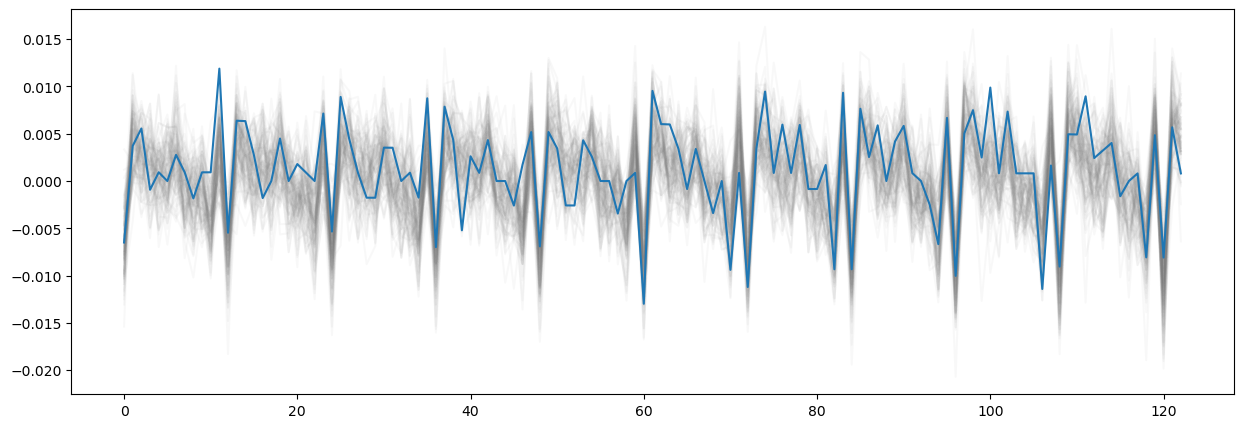

In [100]:
fig = plt.figure(figsize=(15,5))
plt.plot(
    _sample(linear_with_seasonality_posterior_predictive.posterior_predictive['likelihood'][0], 100).T, 
    alpha=.05, 
    color='grey'
)
plt.plot(y)
;

In [101]:
post_season = linear_with_seasonality_trace.posterior['seasonality'].stack(sample=('draw', 'chain')).T

''

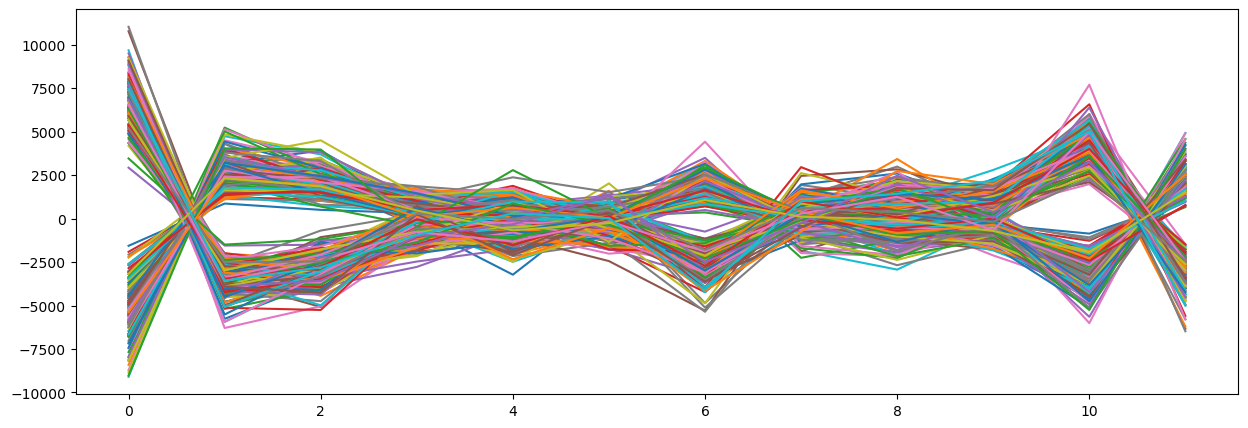

In [114]:
fig = plt.figure(figsize=(15,5))
# plt.plot(linear_with_seasonality_trace.posterior['seasonality'].stack(sample=('draw', 'chain')).T)
plt.plot(_sample(post_season[:, :12], 300).T * 100,)
;

''

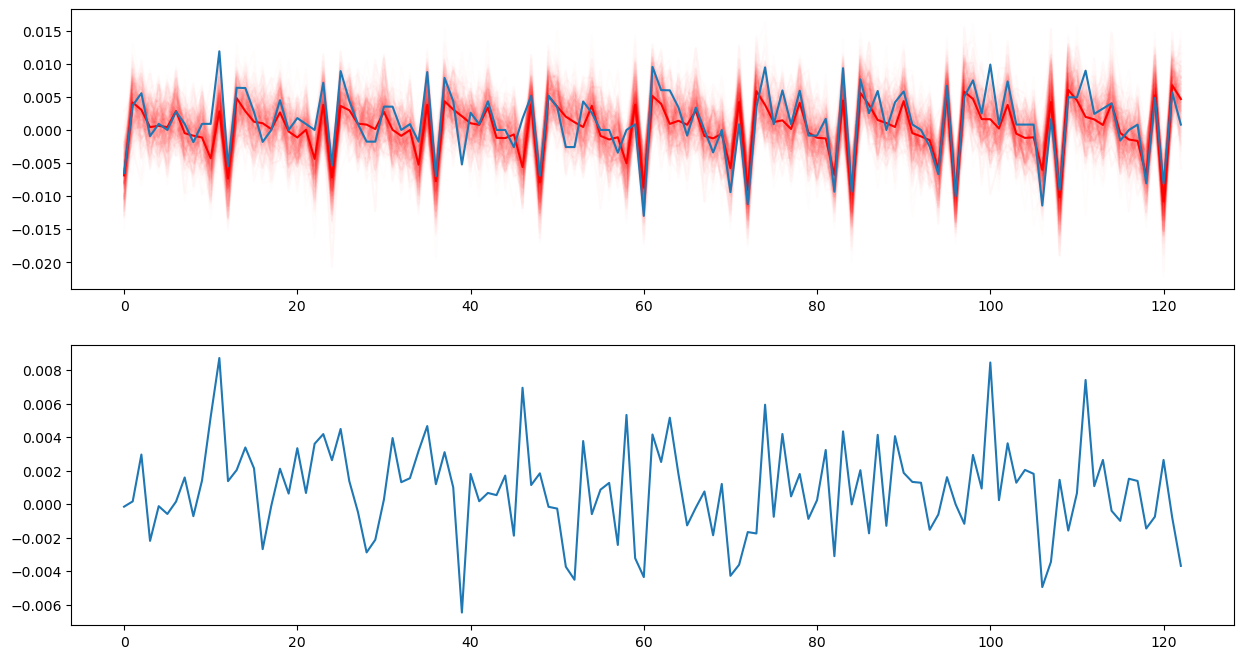

In [452]:
samp = linear_with_seasonality_posterior_predictive.posterior_predictive['likelihood']
resid = (y - samp[0, get_samp(1_000, 200), :].T.median(axis=1)).values


fig, ax = plt.subplots(2, 1, figsize=(15, 8))
ax[0].plot(
    samp[0, get_samp(1_000, 300), :].T,
    alpha=.01, 
    color='red'
)
ax[0].plot(
    samp[0, get_samp(1_000, 200), :].T.median(axis=1),
    color='red',
)
ax[0].plot(y)
ax[1].plot(resid)
;

In [453]:
# forecast

In [454]:
samp = linear_with_seasonality_trace.posterior

In [455]:
trend = np.expand_dims(samp['alpha'][:, get_samp(1_000, 100)].values.ravel(), axis=0) + \
            t_test.reshape(len(t_test), 1) @ np.expand_dims(samp['beta'][:, get_samp(1_000, 100)].values.ravel(), axis=0)
season = (samp['beta_f'].values[:, get_samp(1_000, 100)].reshape(400, 20) @ fourier_features_test.to_numpy().T).T
forecast = trend * (1 + season)

In [456]:
resid_test = y_test - forecast.mean(1)

In [458]:
# nice plot

In [459]:
samp = linear_with_seasonality_posterior_predictive.posterior_predictive['likelihood']

data_mod = samp[:, get_samp(1_000, 100), :].values.reshape(400, len(y))
data_forecast = np.concatenate([np.zeros((400, len(y))) * np.nan, forecast.T], axis=1)

''

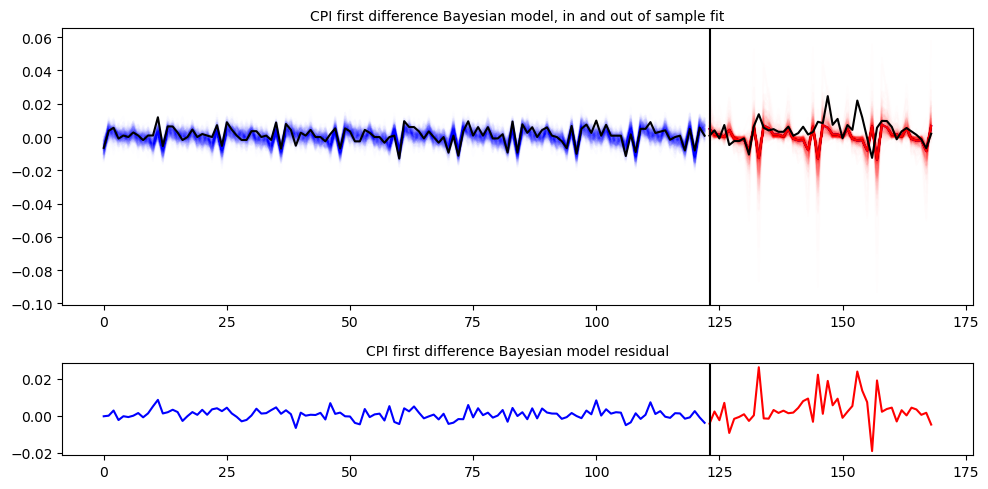

In [460]:
fig, ax = plt.subplots(2,1, figsize=(10,5), gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(data_mod.T, alpha=.0075, color='blue')
ax[0].plot(data_forecast.T.mean(axis=1), color='blue')

ax[0].plot(data_forecast.T, alpha=.0075, color='red')
ax[0].plot(data_forecast.T.mean(axis=1), color='red')

ax[0].plot(y, color='black')
ax[0].plot(np.concatenate([np.zeros(len(y)) * np.nan, y_test]), color='black')

ax[1].plot(resid, color='blue')
ax[1].plot(np.concatenate([np.zeros(len(y)) * np.nan, resid_test]), color='red')

ax[1].plot()

ax[0].axvline(len(y), color='black')
ax[1].axvline(len(y), color='black')

ax[0].set_title('CPI first difference Bayesian model, in and out of sample fit', size=10)
ax[1].set_title('CPI first difference Bayesian model residual', size=10)

plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph1.png'))
;

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

''

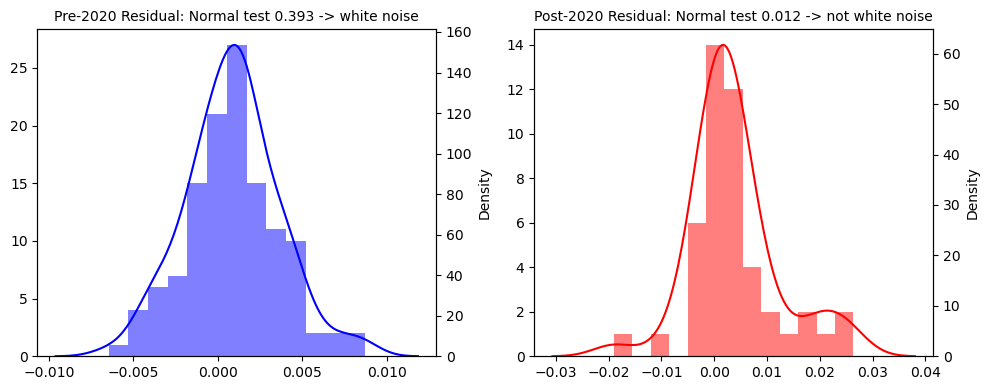

In [461]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].hist(resid, bins='fd', density=False, label='pre-2020', alpha=.5, color='blue', )
sns.kdeplot(resid, ax=ax[0].twinx(), color='blue')
ax[1].hist(resid_test, bins='fd', density=False, label='pos-2020', alpha=.5, color='red')
sns.kdeplot(resid_test, ax=ax[1].twinx(), color='red')

ax[0].set_title(f'Pre-2020 Residual: Normal test {normaltest(resid).pvalue.round(3)} -> white noise', size=10)
ax[1].set_title(f'Post-2020 Residual: Normal test {normaltest(resid_test).pvalue.round(3)} -> not white noise', size=10)
plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph2.png'))

;

In [392]:
# save data

In [444]:
_train['is_train'] = np.zeros(len(_train)) + True
_test['is_train'] = np.zeros(len(_test)) + False

In [445]:
df = pd.concat([_train, _test], axis=0).copy()

In [446]:
df['resid'] = np.concatenate([resid.values, resid_test])

In [447]:
arr = np.concatenate(
    [
        linear_with_seasonality_posterior_predictive.posterior_predictive.likelihood.values[:, get_samp(1_000, 100)].mean(axis=(0,1)),
        forecast.mean(axis=1)
    ]
)

In [448]:
df['pi_mod'] = arr

In [466]:
df['pi_surprise'] = df['resid'] - df['pi_mod']

In [467]:
df.to_csv(os.path.join(DATA_DIR, 'de_inf_prepro.csv'))